In [ ]:
Base.syntax_deprecation_warnings(false)

# GPU 


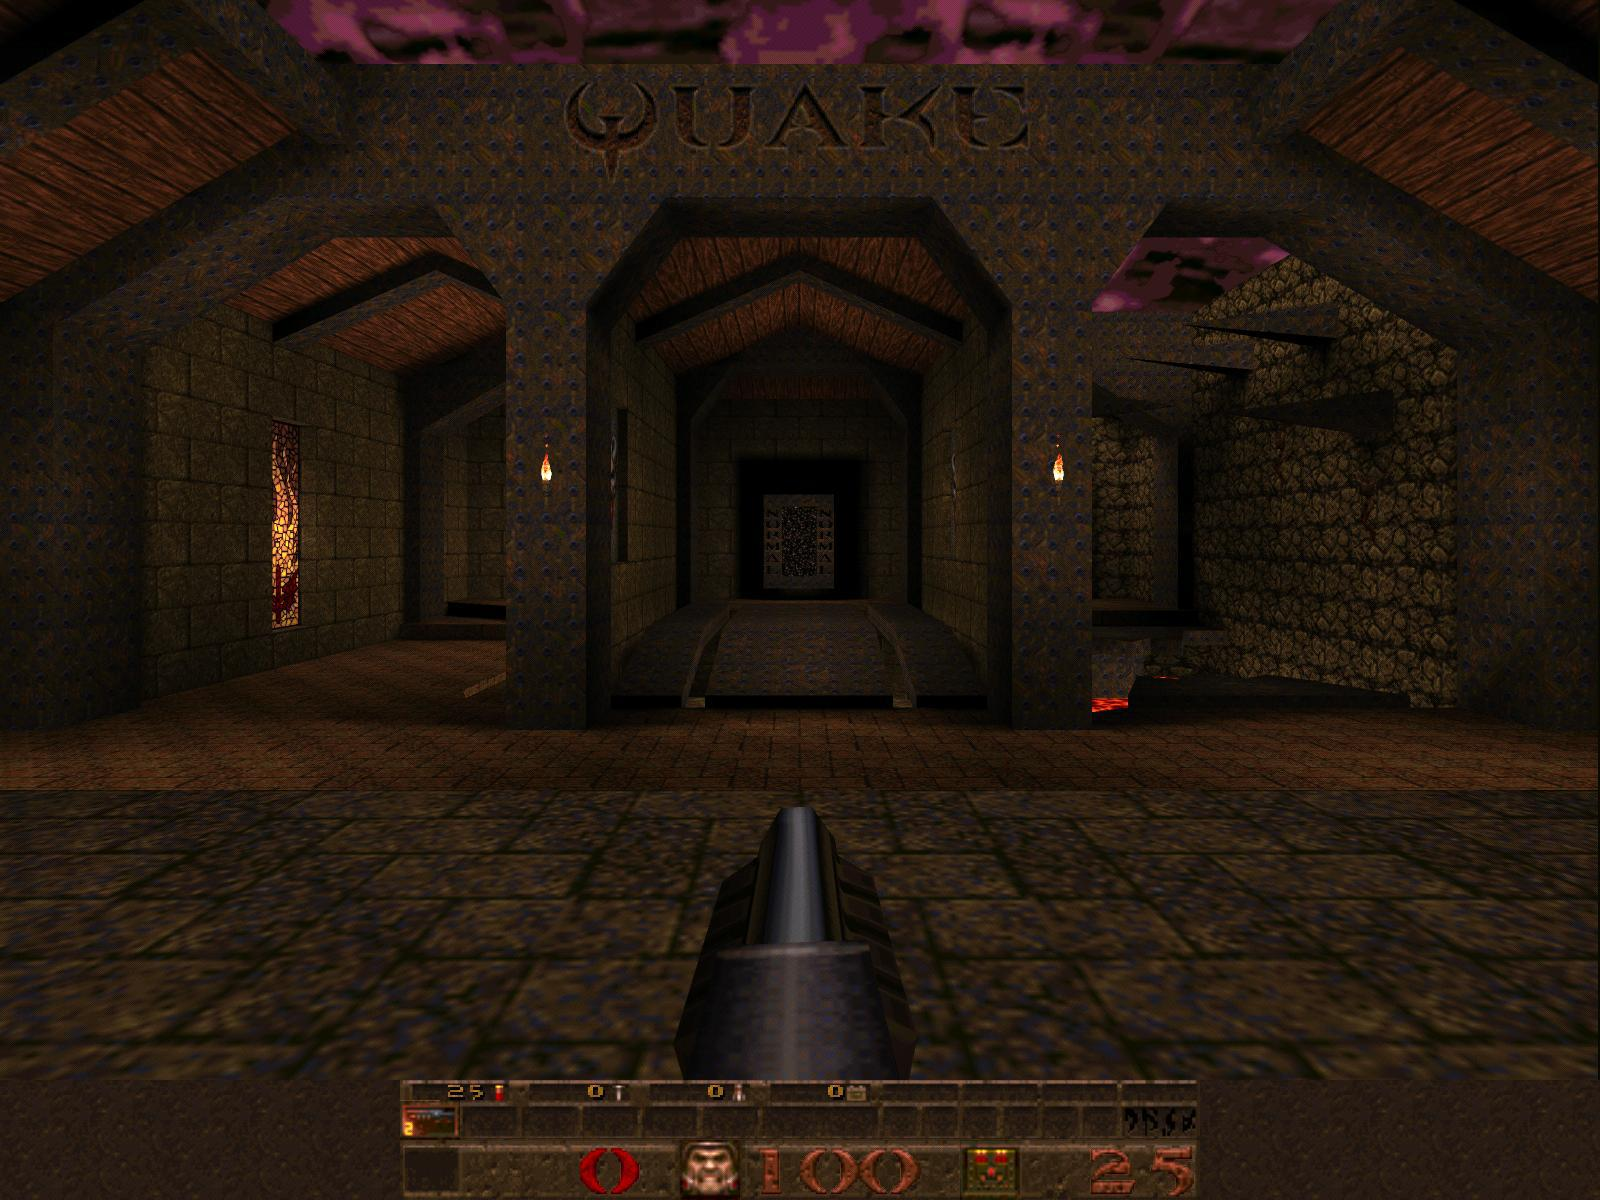


- Developed by video game industry Quake 1
- Massive amount of floating point calculations per video frame 
- Early programming on GPU required problems to be cast to graphic computations


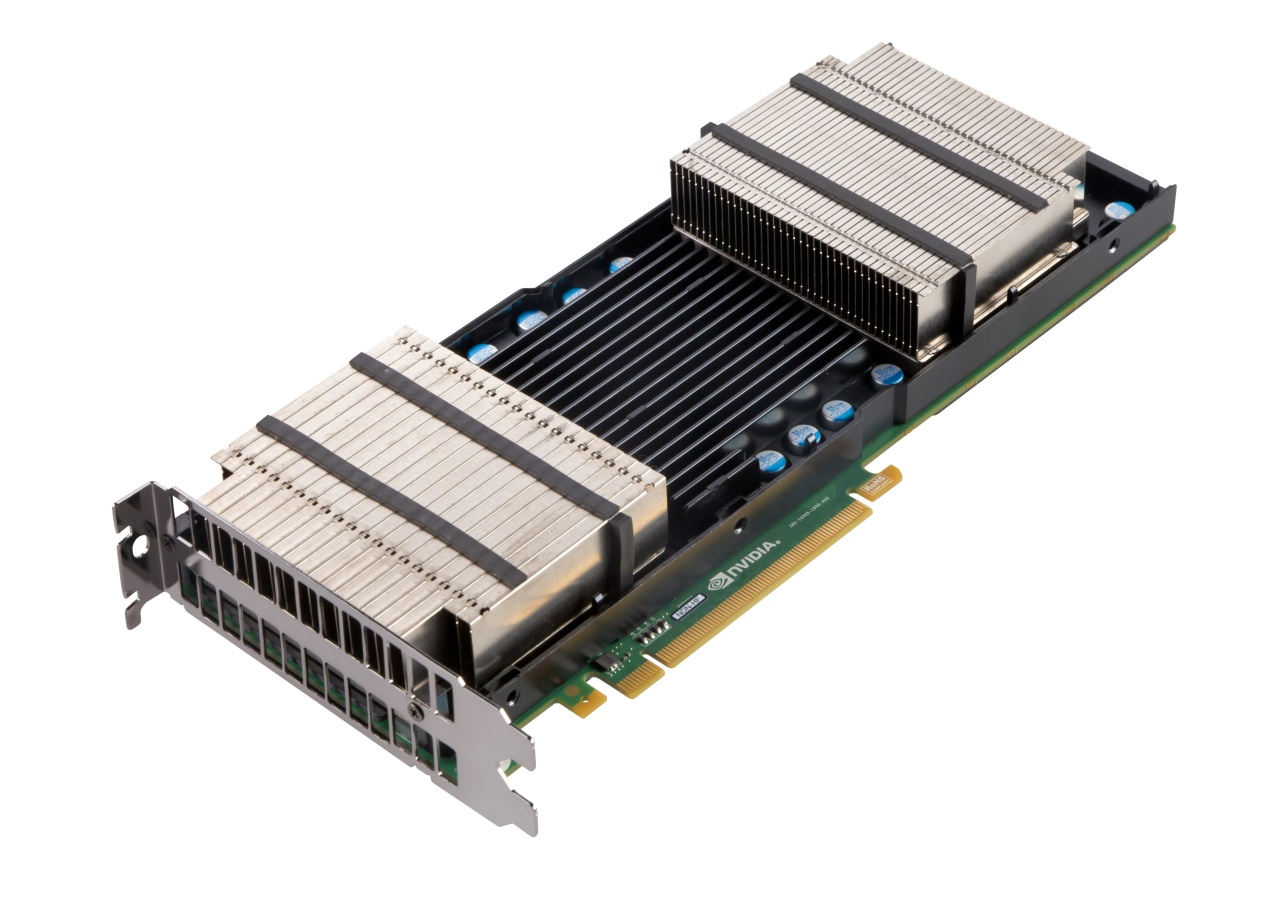

- multi-threaded SIMD processors 
- Each SIMD processor has several SIMD function units (SFU or SIMD cores) that executes the same instructions on different data and a number of load store units (LSU)
- Most GPUs also have a cache memory hierarchy to load data more efficient
- Each Processor keeps an L1 data cache and all processors shares an L2 data cache
- SIMD processors executes several independent SIMD threads that is handled by a thread scheduler
- Number of SIMD processors and SFU is specific to the GPU - hardware
- Number of threads is determined by the application program

# General Purpose GPU 
#### CUDA (Compute Unified Device Architecture) and OpenCL (Open Computing Language)



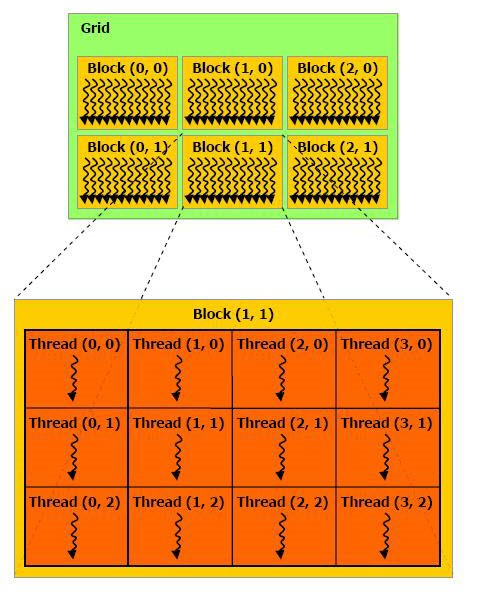

- Program both on host and device
- Device code written in CUDA
- Parallelism resides in the kernel functions
- Calling a kernel function initiates a grid of CUDA threads

- blocks - 2D structure with CUDA keyword blockIdx.x, blockIdx.y
- threads - 3D structure with CUDA keywork threadIdx.x, threadIdx.y, threadIdx.z


- Developed for scientific propramming
- Dynamically typed
- JIT compiled with LLVM
- Performant
- Designed for parallelism and distributed computation
- Solves the 2-languages problem

In [14]:
# Control flow 
a = 1
a == 1 ? b = 1 : b = 0 
b == 0 && println("flow") ;

In [25]:
# Types
a = 1
typeof(a)
b = 2
typeof(b)
c = b/a
typeof(c)

1

In [43]:
# Arrays
a = []
b = Int8[1 2 ; 2 2]
c = rand(Float32,100,100)

100×100 Array{Float32,2}:
 0.230771   0.54605    0.431176   …  0.531667   0.115896    0.383552
 0.336553   0.871085   0.0934484     0.459595   0.183234    0.689988
 0.704818   0.926028   0.867113      0.56794    0.829016    0.323459
 0.923622   0.964104   0.357033      0.561065   0.156004    0.866287
 0.140259   0.508873   0.652553      0.493615   0.698981    0.250409
 0.748393   0.189693   0.775814   …  0.681115   0.955845    0.516256
 0.639564   0.674762   0.54611       0.133147   0.891472    0.124056
 0.851121   0.475025   0.463141      0.0527538  0.00986481  0.133632
 0.358234   0.979879   0.475253      0.500096   0.380644    0.223708
 0.722238   0.555657   0.387733      0.0415279  0.905681    0.980883
 0.577644   0.241007   0.178042   …  0.880283   0.817026    0.223747
 0.697551   0.597531   0.430368      0.169939   0.637511    0.999058
 0.0452445  0.0365354  0.295066      0.289103   0.489315    0.776956
 ⋮                                ⋱                                 
 0.75028

In [47]:
# For loops
for i in [1, 2, 3] # = 1:10
    println(i)
end

1
2
3


In [ ]:
# Multiple dispatch
f(a::Any, b) = "fallback"
f(a::Number, b::Number) = "a and b are both numbers"
f(a::Number, b) = "a is number"
f(1.5, 2)
f(1.5, "2")

# Benchmarks

In [1]:
# Copy last dimension of a n x n x 3 matrix
# A[i][j][1] = A[i][j][2]
# A[i][j][3] = A[i][j][1]
# A[i][j][2] = A[i][j][3] 

# Benchmarks
function foo1(A)
   N = size(A, 1)
   for j = 1:N, i = 1:N
       A[i,j,1] = A[i,j,2]
       A[i,j,3] = A[i,j,1]
       A[i,j,2] = A[i,j,3]
   end
end

dim = 5000
A = randn(dim,dim,3)
tic()
foo1(A)
toc()

A = randn(dim,dim,3)

tic()
A[:,:,1] = A[:,:,2]
A[:,:,3] = A[:,:,1]
A[:,:,2] = A[:,:,3]
toc()

elapsed time: 0.105110177 seconds
elapsed time: 0.562886226 seconds


0.562886226

# SIMD - Single instruction, multiple data

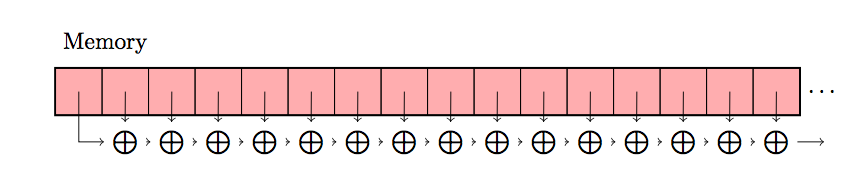
Picture from juliacomputing.com/blog

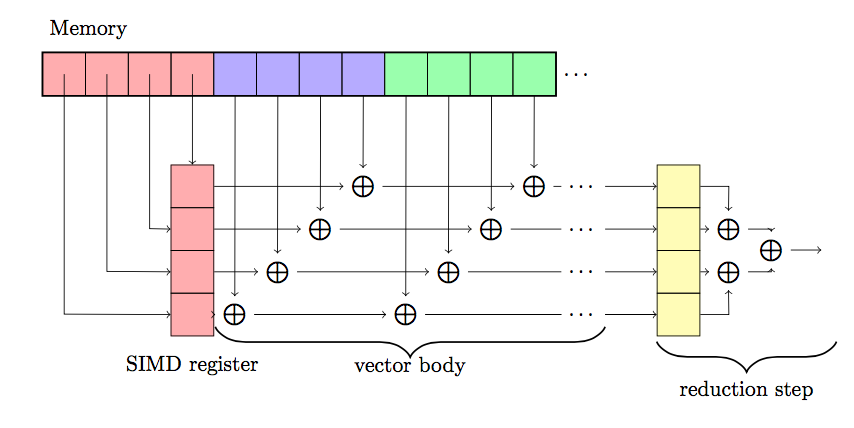
Picture from juliacomputing.com/blog

- All Iterations are independent
- No iteration reads or writes a location that is written by another iteration.
- No iteration waits on another iteration.

In [ ]:
function mysum(a::Vector)
    total = zero(eltype(a))
    @simd for x in a
        total += x
    end
    return total
end

In [ ]:
a = ones(500_000_000)
tic()
mysum(a)
toc()

# CudaNative

In [ ]:
using CUDAdrv, CUDAnative
using Base.Test

function kernel_vadd(a::AbstractVector{Float32}, b::AbstractVector{Float32}, c::AbstractVector{Float32})
    # Don't forget the n-1 dance since Julia is indexed from 1 
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    c[i] = a[i] + b[i]
 
    return nothing
end

In [ ]:
function kernel_dist(X::AbstractVector{Float32}, Y::AbstractVector{Float32}, out::AbstractVector{Float32})
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    out[i] = (X[i]-0.5)^2 + (Y[i]-0.5)^2

    return nothing
end

In [ ]:

dev = CuDevice(0)
ctx = CuContext(dev)

samples = 1000
a = rand(Float32, samples)
b = rand(Float32, samples)

d_a = CuArray(a)
d_b = CuArray(b)
d_c = similar(d_a)
n = length(a)
max_threads = attribute(dev, CUDAdrv.MAX_THREADS_PER_BLOCK)
threads = min(max_threads, n) # Threads available per block
blocks = ceil(Int, n/threads)

@cuda (blocks,threads) kernel_dist(d_a, d_b, d_c)

c = Array(d_c)

destroy!(ctx)

In [ ]:
@test a+b ≈ c

In [ ]:
pi = 4*count(x->x<0.25,c)/length(c)

In [ ]:
using Gadfly
using Colors

In [ ]:
inside = c .< 0.25
outside = c .> 0.25
plot(layer(x=a[inside], y=b[inside], Geom.point,Theme(default_color=colorant"red")),
    layer(x=a[outside], y=b[outside], Geom.point))

# Wrappers

In [2]:
using CuArrays
samples = 1000
a = rand(Float32, (samples,samples))
b = rand(Float32, (samples,samples))
a_cu = cu(a)
b_cu = cu(b)

1000×1000 CuArray{Float32,2}:
 0.658702   0.755907   0.663742    …  0.208492   0.315746   0.135702 
 0.4547     0.791712   0.304722       0.208696   0.708728   0.0705838
 0.949762   0.373022   0.987278       0.921321   0.346261   0.615602 
 0.0931786  0.696067   0.676875       0.361066   0.836271   0.700789 
 0.468044   0.614097   0.423637       0.18145    0.0733417  0.0479181
 0.991285   0.387902   0.190848    …  0.358496   0.656857   0.745432 
 0.294977   0.178141   0.155319       0.614546   0.386781   0.210678 
 0.464166   0.355155   0.205652       0.215863   0.983098   0.862783 
 0.518026   0.38072    0.751824       0.12225    0.0236715  0.309366 
 0.481979   0.93139    0.364686       0.583889   0.12593    0.0376981
 0.14898    0.952801   0.417506    …  0.413604   0.411997   0.452568 
 0.17933    0.503878   0.421344       0.863465   0.0608046  0.311963 
 0.147921   0.0180186  0.204351       0.817002   0.380221   0.784314 
 ⋮                                 ⋱                        

In [ ]:
function matmul(a::AbstractArray, b::AbstractArray)
    for i = 1:10
        r = a * b
    end
end


In [ ]:
tic()
matmul(a_cu, b_cu)
toc()

## Back to Pi

In [ ]:
samples = 1000
a = rand(Float32, samples)
b = rand(Float32, samples)

tic()
c = (a-0.5).^2 .+ (b-0.5).^2
toc()
pi = 4*count(x->x<0.25,c)/length(c)

In [ ]:
tic()
c_cu = (a_cu-0.5).^2 .+ (b_cu-0.5).^2
toc()
c = Array(c_cu)
pi = 4*count(x->x<0.25,c)/length(c)

In [ ]:
# Longer example of CuArray

# CPU VS GPU
- CPU - small number of threads, high data locality, control flow intensive
- GPU - high data parallellism, computationally intensive (not control flow intensive)

# Deep Learning with MXNet

In [ ]:
using MXNet

In [ ]:
a = rand(Float32,(1000))
b = rand(Float32,(1000))
an = mx.empty(1000)
bn = mx.empty(1000)
an[:] = a
bn[:] = b
.*(an,bn)


In [ ]:
# Two code examples GEOPOSITION + Master Thesis to reduce memory consumption

# Structure and types

# LakeTide Curiosa
 - Object Recognition with DNN trained on 4 Terrabyte of image data of insurance cases
 - Trained for a week on 4 GTX 1080 NVIDIA GPU
 

# Links
- www.julialang.org
- www.juliacomputing.com/blog
- www.laketide.com/blog
- https://github.com/dmlc/MXNet.jl
- https://github.com/JuliaGPU/CUDAnative.jl
- https://developer.nvidia.com/cuda-zone